# 코로나, 폐렴, 정상 이미지 분류하기 

1. dataset
- 코로나_페사진 데이터셋[https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset]


`

In [1]:
import os

In [2]:
!pwd/Users/maerad7/Documents/05. 개인프로젝트/02. 코로나_폐렴_정상 이미지 분류/Classification

zsh:1: no such file or directory: pwd/Users/maerad7/Documents/05.


In [3]:
Image_format = ["jpeg","jpg","png"]

def list_image_files(data_dir, sub_dir):
    image_files = []
    images_dir = os.path.join(data_dir, sub_dir)
    for file_path in os.listdir(images_dir):
        if file_path.split(".")[-1] in Image_format:
            image_files.append(os.path.join(sub_dir, file_path))

    return image_files        

In [4]:
!pwd

/Users/maerad7/Documents/05. 개인프로젝트


In [5]:
data_dir = "/Users/maerad7/Documents/05. 개인프로젝트/02. 코로나_폐렴_정상 이미지 분류/data/train"
normal_list = list_image_files(data_dir,"Normal")
covid_list = list_image_files(data_dir,"Covid")
pneumonias_list = list_image_files(data_dir,"Viral Pneumonia")

In [6]:
len(normal_list),len(covid_list),len(pneumonias_list)

(70, 111, 70)

2. 이미지 로딩

In [7]:
import cv2

In [126]:
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

In [9]:
import matplotlib.pyplot as plt
from ipywidgets import interact

In [10]:
min_num_files = min(len(normal_list),len(covid_list),len(pneumonias_list))
print(min_num_files)

70


In [11]:
# 슬라이드 바가 생성 되고 0 부터 69번 인덱스 까지 이동
@interact(index=(0, min_num_files-1))
def show_samples(index=0):
    normal_Image = get_RGB_image(data_dir, normal_list[index])
    covid_Image = get_RGB_image(data_dir,covid_list[index])
    pneumonias_Image = get_RGB_image(data_dir, pneumonias_list[index])
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.title('Normal')
    plt.imshow(normal_Image)
    
    plt.subplot(132)
    plt.title('Covid')
    plt.imshow(covid_Image)
    
    plt.subplot(133)
    plt.title('pneumonias')
    plt.imshow(pneumonias_Image)

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

3. DataSet class

In [12]:
train_data_dir = "/Users/maerad7/Documents/05. 개인프로젝트/02. 코로나_폐렴_정상 이미지 분류/data/train/"
class_list=['Covid','Normal','Viral Pneumonia']

In [14]:
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader


In [48]:
class Chest_dataset(Dataset):
    def __init__(self,data_dir, transform = None):
        self.data_dir = data_dir
        normals = list_image_files(data_dir,"Normal")
        covids = list_image_files(data_dir,"Covid")
        pneumonias = list_image_files(data_dir, "Viral Pneumonia")
        
        self.files_path = normals + covids + pneumonias
        self.transform = transform
    
    def __len__(self):
        return(len(self.files_path))
    
    def __getitem__(self, index):
        image_file = os.path.join(self.data_dir, self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # class_name = self.files_path[index].split(os.sep)[0]
        # class_id = class_list.index(class_name) # class -> id
        target = class_list.index(self.files_path[index].split(os.sep)[0])
        if self.transform:
            image = self.transform(Image.fromarray(image))
            
            target = torch.Tensor([target]).long()
        return image, target

In [49]:
dataset = Chest_dataset(data_dir=train_data_dir)

In [50]:
image, target = dataset[0]

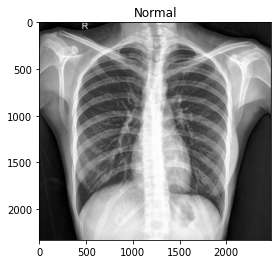

In [51]:
plt.title(class_list[target])
plt.imshow(image)

In [52]:
len(dataset)

251

###

#### 연산가능한 텐서형으로 데이터 변환

In [53]:
import torch
from torchvision import transforms

In [54]:
transform = transforms.Compose([
    transforms.Resize((224,244)),
    transforms.ToTensor(),

    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]
                         )])

In [22]:
train_dataset = Chest_dataset(train_data_dir, transform)

In [23]:
train_dataset = Chest_dataset(train_data_dir, transform)
index = 200
image = train_dataset[index][0]
target = train_dataset[index][1]

print(image.shape)
print(target)
print(type(target))

torch.Size([3, 224, 244])
tensor([2])
<class 'torch.Tensor'>


4. dataloader

In [24]:
from torch.utils.data import DataLoader

In [25]:
torch.__version__

'1.12.0'

In [26]:
train_data_dir = "/Users/maerad7/Documents/05. 개인프로젝트/02. 코로나_폐렴_정상 이미지 분류/data/train/"
val_data_dir = "/Users/maerad7/Documents/05. 개인프로젝트/02. 코로나_폐렴_정상 이미지 분류/data/test/"

train_dataset = Chest_dataset(train_data_dir, transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True) # drop_last : bacth수로 남은 후 쓸지 안쓸지 결정 
val_dataset = Chest_dataset(val_data_dir, transform)
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle=False)

In [27]:
def build_dataloader(train_data_dir, val_data_dir):
    dataloaders={}
    train_dataset = Chest_dataset(train_data_dir, transform)
    dataloaders["train"] = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True) # drop_last : bacth수로 남은 후 쓸지 안쓸지 결정 
    val_dataset = Chest_dataset(val_data_dir, transform)
    dataloaders['val'] = DataLoader(val_dataset, batch_size = 1, shuffle=False)
    return dataloaders

In [28]:
dataloaders = build_dataloader(train_data_dir,val_data_dir)

5. Model
- vgg 19

In [29]:
from torchvision import models

In [30]:
model = models.vgg19(pretrained=True)

/Users/maerad7/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/maerad7/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/maerad7/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
4.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp

In [32]:
from torchsummary import summary
summary(model,(3,224,224),batch_size=1,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

In [35]:
import torch.nn as nn

In [55]:
# nums x nums -> avgvpool(output_size=(1,1)) -> (1,1)

model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256,3),
    # nn.Sigmoid()
)

In [56]:
def build_vgg19_based_model(device="cpu"):
    device = torch.device(device)
    model = models.vgg19(pretrained=True)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(256,3),
        
        
    )
    return model.to(device)

In [57]:
model = build_vgg19_based_model(device="cpu")
summary(model,(3,224,224),batch_size=1, device="cpu")

/Users/maerad7/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/maerad7/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

6. loss

In [59]:
loss_func = nn.CrossEntropyLoss(reduction="mean")

7. Optimization
- SGDM : SGD + momentum

In [60]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # 학습 가능한 모델의 파라미터, learning rate

8. 학습

In [61]:
device = torch.device("cpu")

In [88]:
def train_one_epoch(dataloaders, model, optimizer, loss_function, device):
    losses = {}
    accuracies = {}
    
    for phase in ["train", "val"]:
        running_loss = 0.0
        running_correct = 0
        
        if phase == "train":
            model.train()
        else:
            model.eval()
            
        for index, batch in enumerate(dataloaders[phase]):
            image = batch[0].to(device)
            target = batch[1].squeeze(dim=1).to(device)

            with torch.set_grad_enabled(phase == "train"):
                prediction = model(image)
                loss = loss_func(prediction, target)
                
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image, target, model)
            
            if phase == "train":
                if index % 10 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
            
        losses[phase] = running_loss / len(dataloaders[phase])
        accuracies[phase] = running_correct / len(dataloaders[phase])
    return losses, accuracies

9. Accuracy
- top-1 : 가장 confidence가 높은 예측 값의 클래스가 gorund truth와 일치하는 경우
- top-5 : 상위 5개의 confidence가 예측 값의 클래스에 gorund truth가 존재하는 경우

In [96]:
@torch.no_grad()
def get_accuracy(image, target, model):
    batch_size = image.shape[0]
    prediction = model(image)
    _, pred_label = torch.max(prediction, dim=1)
    is_correct = (pred_label == target)
    return is_correct.cpu().numpy().sum() / batch_size

10. 학습실행

In [98]:
import copy
def save_best_model(model_state, model_name, save_dir="./trained_model"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

In [99]:
num_epochs = 10

best_acc = 0.0
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    train_loss.append(losses["train"])
    val_loss.append(losses["val"])
    train_accuracy.append(accuracies["train"])
    val_accuracy.append(accuracies["val"])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss: {losses['train']}, Val Loss: {losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc: {accuracies['train']}, Val Acc: {accuracies['val']}")
    
    if (epoch > 3) and (accuracies["val"] > best_acc):
        best_acc = accuracies["val"]
        best_model = copy.deepcopy(model.state_dict())
        save_best_model(best_model, f"model_{epoch+1:02d}.pth")
        
print(f"Best Accuracy: {best_acc}")

0/62 - Running loss: 0.48602837324142456
10/62 - Running loss: 0.238827183842659
20/62 - Running loss: 0.3010888397693634
30/62 - Running loss: 0.20047622919082642
40/62 - Running loss: 0.05661853402853012
50/62 - Running loss: 1.0109471082687378
60/62 - Running loss: 0.1393304318189621
1/10-Train Loss: 0.3888849351825493, Val Loss: 0.365146596321045
1/10-Train Acc: 0.8830645161290323, Val Acc: 0.8939393939393939
0/62 - Running loss: 0.07370871305465698
10/62 - Running loss: 0.17872953414916992
20/62 - Running loss: 0.02114102989435196
30/62 - Running loss: 0.030186669901013374
40/62 - Running loss: 0.4425237774848938
50/62 - Running loss: 0.07002128660678864
60/62 - Running loss: 0.21432332694530487
2/10-Train Loss: 0.17141536337646446, Val Loss: 0.24895999944271893
2/10-Train Acc: 0.967741935483871, Val Acc: 0.8787878787878788
0/62 - Running loss: 0.061328355222940445
10/62 - Running loss: 0.0013854952994734049
20/62 - Running loss: 1.4036771972314455e-05
30/62 - Running loss: 0.0001

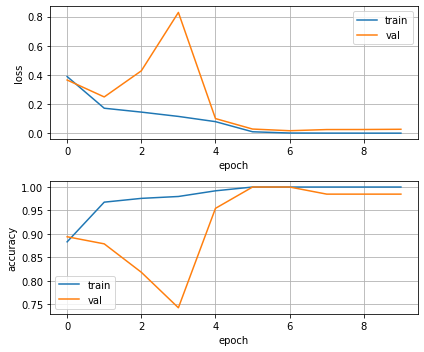

In [100]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label="train")
plt.plot(val_loss,  label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.subplot(212)
plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy, label="val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()
plt.tight_layout()

11. 성능 검증

In [140]:
test_normals_list=[]
test_covids_list=[]
test_pneumonias_list=[]
test_dir = "/Users/maerad7/Documents/05. 개인프로젝트/02. 코로나_폐렴_정상 이미지 분류/data/test"
test_normals_list = list_image_files(test_dir,"Normal")
test_covids_list = list_image_files(test_dir,"Covid")
test_pneumonias_list = list_image_files(test_dir,"Viral Pneumonia")

In [150]:
def preprocess_image(image):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 244)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
    ])
    
    tensor_image = transformer(image)  # (C, H, W)
    tensor_image = tensor_image.unsqueeze(0) # (B, C, H, W) 배치 사이즈 추가 (1)
    return tensor_image

In [156]:
@torch.no_grad()
def model_predict(image, model):
    tensor_image = preprocess_image(image)
    prediction = model(tensor_image)
    
    _, pred_label = torch.max(prediction.detach().cpu(), dim=1) # 그래프에서 detach // (B,num_class) 
    pred_label = pred_label.squeeze(dim=0) # (B, 1) -> (1) 
    return pred_label.item() # torch 변수의 스칼라 값만 가져옴

In [157]:
ckpt = torch.load("./trained_model/model_06.pth")

model = build_vgg19_based_model(device='cpu')
model.load_state_dict(ckpt)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [158]:
def get_RGB_image(data_dir, file_name):
    image_file = os.path.join(data_dir, file_name)
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [159]:
min_num_files = min(len(test_normals_list), len(test_covids_list), len(test_pneumonias_list))

@interact(index=(0, min_num_files-1))
def show_result(index=0):
    normal_image = get_RGB_image(test_dir, test_normals_list[index])
    covid_image = get_RGB_image(test_dir, test_covids_list[index])
    pneumonia_image = get_RGB_image(test_dir, test_pneumonias_list[index])
    
    prediction_1 = model_predict(normal_image, model)
    prediction_2 = model_predict(covid_image, model)
    prediction_3 = model_predict(pneumonia_image, model)
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.title(f"Pred:{class_list[prediction_1]} | GT:Normal")
    plt.imshow(normal_image)
    plt.subplot(132)
    plt.title(f"Pred:{class_list[prediction_2]} | GT:Covid")
    plt.imshow(covid_image)
    plt.subplot(133)
    plt.title(f"Pred:{class_list[prediction_3]} | GT:Pneumonia")
    plt.imshow(pneumonia_image)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=19), Output()), _dom_classes=('widget-intera…